In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import re
import json
import requests
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings(action = 'ignore')

In [3]:
# 구별로 json 불러오기

url = 'https://www.daegufood.go.kr/kor/api/tasty.html?mode=json&addr='
url_jung = url + '%EC%A4%91%EA%B5%AC'
url_dong = url + '%EB%8F%99%EA%B5%AC'
url_seo = url + '%EC%84%9C%EA%B5%AC'
url_nam = url + '%EB%82%A8%EA%B5%AC'
url_buk = url + '%EB%B6%81%EA%B5%AC'
url_su = url + '%EC%88%98%EC%84%B1%EA%B5%AC'
url_dal = url + '%EB%8B%AC%EC%84%9C%EA%B5%AC'
url_daln = url + '%EB%8B%AC%EC%84%B1%EA%B5%B0'

r_jung = requests.get(url_jung)
r_dong = requests.get(url_dong)
r_seo = requests.get(url_seo)
r_nam = requests.get(url_nam)
r_buk = requests.get(url_buk)
r_su = requests.get(url_su)
r_dal = requests.get(url_dal)
r_daln = requests.get(url_daln)

json_jung = r_jung.json(strict=False)
json_dong = r_dong.json(strict=False)
json_seo = r_seo.json(strict=False)
json_nam = r_nam.json(strict=False)
json_buk = r_buk.json(strict=False)
json_su = r_su.json(strict=False)
json_dal = r_dal.json(strict=False)
json_daln = r_daln.json(strict=False)

dg_mat = [json_jung, json_dong, json_seo, json_nam, json_buk, json_su, json_dal, json_daln]

In [4]:
dg_list=[]
for i in range (len(dg_mat)) :
    for j in range (len(dg_mat[i]['data'])) :
        dg_list.append((dg_mat[i]['data'][j]['BZ_NM'], dg_mat[i]['data'][j]['GNG_CS']))

adr = pd.DataFrame(dg_list, columns=['name', 'address'])

adr.head()

,name,address
0,송림식당,대구광역시 중구 삼덕동2가 219-1
1,빈플러스 테이스팅 스푼(TASTING SPOON),대구광역시 중구 삼덕동1가 21-10
2,박석규 중앙떡볶이,대구광역시 중구 동성로2가 70-1
3,가스트로락,대구광역시 중구 대봉동 31-67
4,차이,대구광역시 중구 삼덕동1가 14-3


In [5]:
status_success = 0
adr_json = []

for i in tqdm_notebook(range(len(adr))) :   
    q = adr['address'][i]
    api = f'https://api.vworld.kr/req/address?service=address&request=getcoord&version=2.0&crs=epsg:4326&address={q}&refine=true&simple=false&format=json&type=parcel&key=52C3080F-5F83-335E-B72D-6E5156073F68'
    req = requests.get(api)

    status_success+=1 if req.status_code==200 else print(f'{i}번째에서 에러남', status_code)
    

    adr_json.append(req.json())
       
print('925 나오면 req 전부 양호 :', status_success)
        
        


925 나오면 req 전부 양호 : 925


In [6]:
adr_json[0]

{'response': {'service': {'name': 'address',
   'version': '2.0',
   'operation': 'getcoord',
   'time': '179(ms)'},
  'status': 'OK',
  'input': {'type': 'parcel', 'address': '대구광역시 중구 삼덕동2가 219-1'},
  'refined': {'text': '대구광역시 중구 삼덕동2가 219-1',
   'structure': {'level0': '대한민국',
    'level1': '대구광역시',
    'level2': '중구',
    'level3': '',
    'level4L': '삼덕동2가',
    'level4LC': '2711010600',
    'level4A': '삼덕동',
    'level4AC': '2711054500',
    'level5': '219-1',
    'detail': ''}},
  'result': {'crs': 'EPSG:4326',
   'point': {'x': '128.603541305001', 'y': '35.864931923605'}}}}

In [7]:
# 데이터를 확인하던 중 status가 'NOT_FOUND'인 데이터들이 있는 것을 찾았다.
adr_json[900]

{'response': {'service': {'name': 'address',
   'version': '2.0',
   'operation': 'getcoord',
   'time': '115(ms)'},
  'status': 'NOT_FOUND',
  'record': {'total': '0', 'current': '0'},
  'page': {'total': '1', 'current': '1', 'size': '10'}}}

In [8]:
# 확인해보니 주소가 이런식으로 들어있어서 주소변환이 불가능 한 것이었다.
# 이런걸 일일이 수정해줄 수 없으니 그냥 제거하도록 한다...
adr.loc[900]

name                       가창우록리먹거리마을
address    대구광역시 달성군 가창면 우록리 / 삼산리 일대
Name: 900, dtype: object

In [9]:
# status가 OK인 것만 가져온다.
all_xy=[]

for i in range(len(adr_json)) :
    if adr_json[i]['response']['status'] == 'OK' :
        all_xy.append((adr_json[i]['response']['result']['point']['x'],
                       adr_json[i]['response']['result']['point']['y']))

In [10]:
print(len(all_xy), 925-len(all_xy))
# 925개 주소 중 57개가 문제가 있어 제거했고 데이터는 868개가 되었다.

868 57


In [11]:
# 구별로 따로 담아준다.
jung_xy=[]
dong_xy=[]
seo_xy=[]
nam_xy=[]
buk_xy=[]
su_xy=[]
dal_xy=[]
daln_xy=[]

for i in range(len(adr_json)) :
    if adr_json[i]['response']['status'] == 'OK' :
        if adr_json[i]['response']['refined']['structure']['level2'] == '중구' :
            jung_xy.append((adr_json[i]['response']['result']['point']['x'],
                             adr_json[i]['response']['result']['point']['y']))
        elif adr_json[i]['response']['refined']['structure']['level2'] == '동구' :
            dong_xy.append((adr_json[i]['response']['result']['point']['x'],
                             adr_json[i]['response']['result']['point']['y']))    
        elif adr_json[i]['response']['refined']['structure']['level2'] == '서구' :
            seo_xy.append((adr_json[i]['response']['result']['point']['x'],
                             adr_json[i]['response']['result']['point']['y']))   
        elif adr_json[i]['response']['refined']['structure']['level2'] == '남구' :
            nam_xy.append((adr_json[i]['response']['result']['point']['x'],
                             adr_json[i]['response']['result']['point']['y']))   
        elif adr_json[i]['response']['refined']['structure']['level2'] == '북구' :
            buk_xy.append((adr_json[i]['response']['result']['point']['x'],
                             adr_json[i]['response']['result']['point']['y']))
        elif adr_json[i]['response']['refined']['structure']['level2'] == '수성구' :
            su_xy.append((adr_json[i]['response']['result']['point']['x'],
                             adr_json[i]['response']['result']['point']['y']))   
        elif adr_json[i]['response']['refined']['structure']['level2'] == '달서구' :
            dal_xy.append((adr_json[i]['response']['result']['point']['x'],
                             adr_json[i]['response']['result']['point']['y']))   
        elif adr_json[i]['response']['refined']['structure']['level2'] == '달성군' :
            daln_xy.append((adr_json[i]['response']['result']['point']['x'],
                             adr_json[i]['response']['result']['point']['y']))   

In [12]:
# 리스트 -> 데이터프레임
df_jung_xy = pd.DataFrame(jung_xy, columns=['x_longitude', 'y_latitude'])
df_dong_xy = pd.DataFrame(dong_xy, columns=['x_longitude', 'y_latitude'])
df_seo_xy = pd.DataFrame(seo_xy, columns=['x_longitude', 'y_latitude'])
df_nam_xy = pd.DataFrame(nam_xy, columns=['x_longitude', 'y_latitude'])
df_buk_xy = pd.DataFrame(buk_xy, columns=['x_longitude', 'y_latitude'])
df_su_xy = pd.DataFrame(su_xy, columns=['x_longitude', 'y_latitude'])
df_dal_xy = pd.DataFrame(dal_xy, columns=['x_longitude', 'y_latitude'])
df_daln_xy = pd.DataFrame(daln_xy, columns=['x_longitude', 'y_latitude'])

# object형 -> float형
df_jung_xy = df_jung_xy.astype(float)
df_dong_xy = df_dong_xy.astype(float)
df_seo_xy = df_seo_xy.astype(float) 
df_nam_xy = df_nam_xy.astype(float) 
df_buk_xy = df_buk_xy.astype(float) 
df_su_xy = df_su_xy.astype(float)
df_dal_xy = df_dal_xy.astype(float) 
df_daln_xy = df_daln_xy.astype(float)

In [46]:
#xy.to_csv('대구xy.csv', index=False)

In [47]:
#xy = pd.read_csv('대구xy.csv')

In [358]:
data = np.array(df_jung_xy)

In [239]:
k = 10

In [359]:
# 각 점들이 centers들과 얼마나 떨어져 있는지 각각 거리 비교할 때 사용
# 거리 '측정'이 아닌 '비교'라서 루트를 씌우든 안 씌우든 비교하는데에는 상관이 없기 때문에 굳이 루트를 씌울 필요는 없다.
# c: centers(x,y),  o: others(x,y)
def distance(c, o):
    return sum((c - o) ** 2)/len(c)


def group_center(g):
    g = np.array(g)
    return g.mean(axis=0)


def cluster(data, k, seed=2022, iter_num=25):
    logs = []
    np.random.seed(seed)
    centers = data[np.random.choice(len(data), size=k, replace=False)]
    for it in range(iter_num):
        group = {}
        for i in range(k):
            group[i] = []
        # find nearest center
        for row in data:
            temp = []
            for i in range(k):
                temp.append(distance(centers[i], row))
            group[np.argmin(temp)].append(row.tolist())

        # plot data store
        for i in range(k):
            group_temp = np.array(group[i])
            group_temp = np.c_[group_temp, np.full(len(group_temp), i)]
            if i == 0:
                grouped = group_temp
            else:
                grouped = np.append(grouped, group_temp, axis = 0)

        # update center
        centers_new = []
        for i in range(k):
            centers_new.append(group_center(group[i]).tolist())
        centers_new = np.array(centers_new)
        # if updated center == center, break

        if np.sum(centers - centers_new) == 0:
            break
        else:
            centers = centers_new
            logs.append(grouped)
    return grouped, logs, it  



In [360]:
grouped, logs, it = cluster(data, k)
print(f'iter num:{it}') # 반복횟수

iter num:3


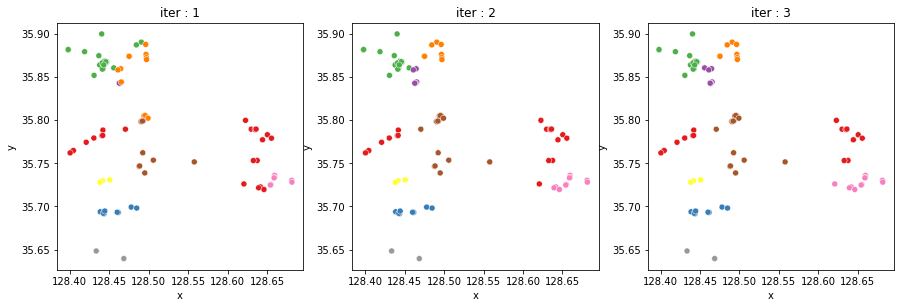

In [361]:
# 중구 클러스터링 시각화
plt.figure(figsize=(15,(it//3+1)*5)) # figsize 중 세로 길이는 도표수에 비례해서 정한다.
for i in range(it):
    plt.subplot(it//3+1, 3, i+1)  # row, col, index
    df = pd.DataFrame(logs[i])
    df.columns = ['x', 'y', 'group']
    sns.scatterplot(data = df, x = 'x', y = 'y', hue = 'group', palette='Set1').set_title(f'iter : {i+1}')
    plt.legend([],[], frameon=False) # 범례를 비워서 안 보이게 함. # 아예 remove하는 방법도 있는데 여기서는 안 됨

중구를 k=10으로 클러스터링 하면 13번의 반복을 거쳐야 한다.

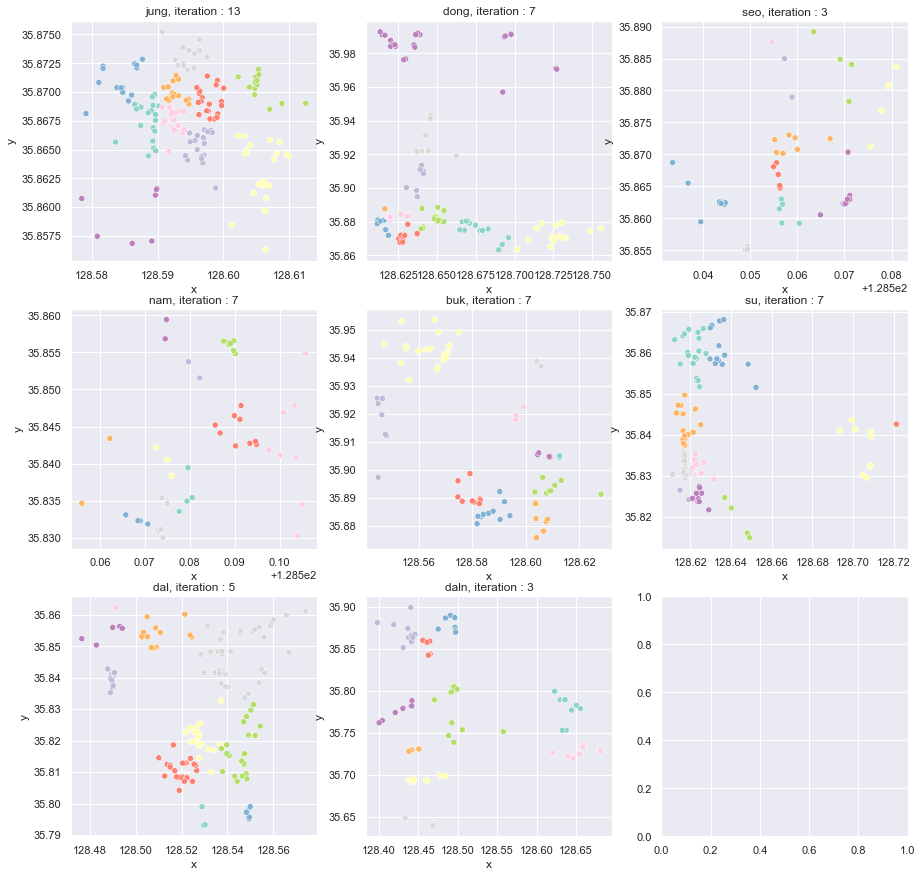

In [380]:
# 모든 구 시각화하기
# 반복문을 써서 코드를 줄이고 싶었지만 잘 안 먹혀서 그냥 적었다ㅠㅠ
k=10

figure, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(nrows=3, ncols=3)
figure.set_size_inches(15,15)

sns.set(rc={'axes.facecolor':'darkgray'})

data = np.array(df_jung_xy)
grouped, logs, it = cluster(data, k)
df = pd.DataFrame(logs[it-1])
df.columns = ['x', 'y', 'group']
sns.scatterplot(data = df, x = 'x', y = 'y', hue = 'group', palette='Set3', ax=ax1, legend = False).set_title(f'jung, iteration : {it}')

data = np.array(df_dong_xy)
grouped, logs, it = cluster(data, k)
df = pd.DataFrame(logs[it-1])
df.columns = ['x', 'y', 'group']
sns.scatterplot(data = df, x = 'x', y = 'y', hue = 'group', palette='Set3', ax=ax2, legend = False).set_title(f'dong, iteration : {it}')

data = np.array(df_seo_xy)
grouped, logs, it = cluster(data, k)
df = pd.DataFrame(logs[it-1])
df.columns = ['x', 'y', 'group']
sns.scatterplot(data = df, x = 'x', y = 'y', hue = 'group', palette='Set3', ax=ax3, legend = False).set_title(f'seo, iteration : {it}')

data = np.array(df_nam_xy)
grouped, logs, it = cluster(data, k)
df = pd.DataFrame(logs[it-1])
df.columns = ['x', 'y', 'group']
sns.scatterplot(data = df, x = 'x', y = 'y', hue = 'group', palette='Set3', ax=ax4, legend = False).set_title(f'nam, iteration : {it}')

data = np.array(df_buk_xy)
grouped, logs, it = cluster(data, k)
df = pd.DataFrame(logs[it-1])
df.columns = ['x', 'y', 'group']
sns.scatterplot(data = df, x = 'x', y = 'y', hue = 'group', palette='Set3', ax=ax5, legend = False).set_title(f'buk, iteration : {it}')

data = np.array(df_su_xy)
grouped, logs, it = cluster(data, k)
df = pd.DataFrame(logs[it-1])
df.columns = ['x', 'y', 'group']
sns.scatterplot(data = df, x = 'x', y = 'y', hue = 'group', palette='Set3', ax=ax6, legend = False).set_title(f'su, iteration : {it}')

data = np.array(df_dal_xy)
grouped, logs, it = cluster(data, k)
df = pd.DataFrame(logs[it-1])
df.columns = ['x', 'y', 'group']
sns.scatterplot(data = df, x = 'x', y = 'y', hue = 'group', palette='Set3', ax=ax7, legend = False).set_title(f'dal, iteration : {it}')

data = np.array(df_daln_xy)
grouped, logs, it = cluster(data, k)
df = pd.DataFrame(logs[it-1])
df.columns = ['x', 'y', 'group']
sns.scatterplot(data = df, x = 'x', y = 'y', hue = 'group', palette='Set3', ax=ax8, legend = False).set_title(f'daln, iteration : {it}')

plt.show()